# The Code

In [74]:
import numpy as np
from fontTools.misc.cython import returns
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [75]:
from sklearn.decomposition import FastICA

def performICA(data, heartbeats_only=True):
    heartbeats = []
    ica = FastICA(n_components=4)
    data = data.T
    components = ica.fit_transform(data)
    for i in range(4):
        component = components[:, i]
        if np.min(component) < -2: component *= -1
        if np.max(component) > 4: heartbeats.append(component)
        if not heartbeats_only and np.max(component) <= 5: heartbeats.append(5)
    return heartbeats

## load Data and apply ICA 

In [76]:
file_range = range(153)
all_heartbeats = []
for i in file_range:
    filename = f'{i}'.zfill(3)
    data = loadmat(f'heartbeat_data/{filename}.mat')
    data_matrix = np.array(data['val'][0])
    heartbeats = performICA(data_matrix)
    for h in heartbeats:
        all_heartbeats.append((h, filename))

In [ ]:
!pip install heartpy

In [77]:
import heartpy as hp
from scipy.signal import find_peaks

def check_rotation(component, sr):
    distance = sr/10
    _, properties = find_peaks(component, distance=distance, height=0.1 * np.max(component))
    _ , inverted_properties = find_peaks(-component, distance=distance, height=0.1 * np.max(-component))

    # calculate average peak height for normal and inverted peaks to determine if signal is upside down or not
    avg_peak_height = np.mean(properties['peak_heights']) 
    avg_inv_peak_height = np.mean(inverted_properties['peak_heights']) 

    # flip signal if inverted peaks are taller
    if avg_inv_peak_height > avg_peak_height:
        component = -component

    return component

def calculate_heartrate(component, sr):
    component = check_rotation(component, sr)
    working_data, measures, heart_rate = None, None, None

    # Analyze the component signal with HeartPy
    working_data, measures = hp.process(component, sample_rate=sr)

    return component, working_data, measures

In [78]:
import warnings
warnings.simplefilter('ignore')

heartbeatsWithBpm = np.zeros(len(all_heartbeats), dtype=tuple)

for i, heartbeat in enumerate(all_heartbeats):
    try:
        component, working_data, measures = calculate_heartrate(heartbeat[0], 360)
        heartbeatsWithBpm[i] = (heartbeat[0], heartbeat[1], measures['bpm'], measures['pnn50'])
    except:
        heartbeatsWithBpm[i] = (None, None, None, None)
        continue

## Divide signals into fetal and Maternal Signals

In [80]:
mother = []
fetus = []

fetusBpmMin = 110

for hb in heartbeatsWithBpm:
    if hb[2] == None:
        continue
    if hb[2] >= fetusBpmMin: fetus.append((hb[0],hb[1]))
    elif hb[2] < fetusBpmMin: mother.append((hb[0],hb[1]))

## @ New Alignment of  each signal to the first fetal signal recorded at 000.mat

### Method: Dynamy Time Warping

In [81]:
print(len(fetus))

138


In [99]:
# Print out the name to make sure we really got the file 000.mat
central_heartbeat = fetus[0]
central_heartbeat

(array([-0.36300318, -0.27301603, -0.29009801, ...,  0.39512346,
         0.36169046,  0.23049564]),
 '000')

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


aligned_heartbeats = []
for hp in fetus:
    # Example time series
    a = central_heartbeat[0]
    b = hp[0]
    
    # Reshape inputs to 2D (each point is a 1D vector)
    # fastdtw expects inputs as sequences of vectors (e.g., 2D arrays, even for 1D time series)
    
    a_reshaped = a.reshape(-1, 1)
    b_reshaped = b.reshape(-1, 1)
    # Compute fast DTW
    distance, path = fastdtw(a_reshaped, b_reshaped, dist=euclidean)
    
    # If b is longer than a, down-sample b using the DTW path
    aligned_b = []
    
    # Ensure that b aligns with a by down-sampling or repeating points from b
    for i in range(len(a)):  # Iterate over each point in a
        # Find the closest matching index in b (from the DTW path)
        closest_b_index = [j for (i_, j) in path if i_ == i]
        if closest_b_index:
            aligned_b.append(b[closest_b_index[0]])  
    # Convert to numpy arrays
    aligned_b = np.array(aligned_b) 
   
    aligned_heartbeats.append((aligned_b,hp[1]))

In [114]:
len(aligned_heartbeats)

138

In [115]:
len(aligned_heartbeats[1][0])

1500

In [116]:
len(aligned_heartbeats[3][0])

1500

In [120]:
aligned_heartbeats[3][1]

'002'

## Example of alignment with Dynamic Time Warping from FastDTW package

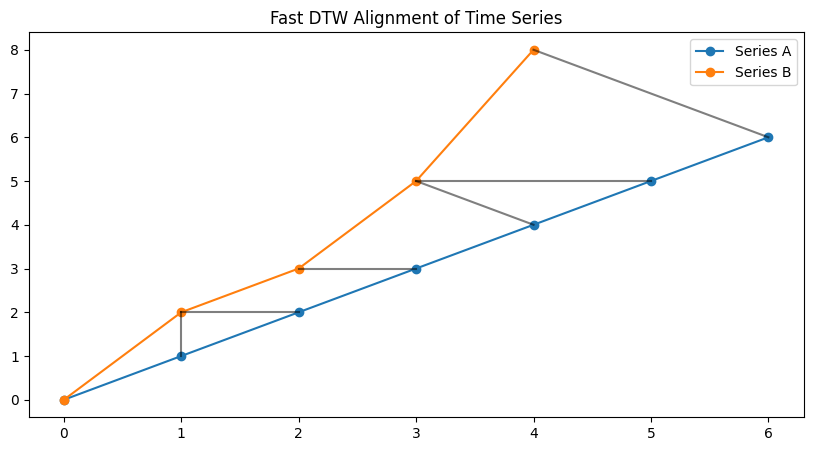

Distance between the two series: 4.0
Path for alignment (a -> b): [(0, 0), (1, 1), (2, 1), (3, 2), (4, 3), (5, 3), (6, 4)]
Aligned Series A: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Aligned Series B: [np.int64(0), np.int64(2), np.int64(2), np.int64(3), np.int64(5), np.int64(5), np.int64(8)]


In [89]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Example time series
a = np.array([0, 1, 2, 3, 4, 5, 6])
b = np.array([0, 2, 3, 5, 8])

# Reshape inputs to 2D (each point is a 1D vector)
# fastdtw expects inputs as sequences of vectors (e.g., 2D arrays, even for 1D time series)

a_reshaped = a.reshape(-1, 1)
b_reshaped = b.reshape(-1, 1)

# Compute fast DTW
distance, path = fastdtw(a_reshaped, b_reshaped, dist=euclidean)

# Extract aligned series
aligned_a = [a[i] for i, _ in path]
aligned_b = [b[j] for _, j in path]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(a, label="Series A", marker="o")
plt.plot(b, label="Series B", marker="o")
for (i, j) in path:
    plt.plot([i, j], [a[i], b[j]], "k-", alpha=0.5)
plt.legend()
plt.title("Fast DTW Alignment of Time Series")
plt.show()

# Print results
print("Distance between the two series:", distance)
print("Path for alignment (a -> b):", path)
print("Aligned Series A:", aligned_a)
print("Aligned Series B:", aligned_b)


## Features for Clustering
Aligned Signal:
- Signals of formerly different lengths now have the same length 

Matrix profile of aligned Signal: 
- Captures Anomalies within a time series, the peaks (highes distance) within the matrix profile indicate anomalies within a tim series 
- is shorter that the original signal:
- normalize matrix profile values
Input time series length: n
Subsequence length: m
Matrix Profile length: n−m+1

Frequency:
- 1 number  for example the dominat frequency 


## Step 1 Apply PCA to aligned Heartbeat Signals

In [122]:
aligned_heartbeats_Matrix = np.array([aligned_heartbeat[0] for aligned_heartbeat in aligned_heartbeats])
aligned_heartbeats_Matrix.shape

(138, 1500)

In [123]:
# Function to compute and visualize cumulative variance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
def plot_cumulative_variance(explained_variance_ratio, max_components=None):
    """
    Plots the cumulative variance explained by the first n principal components.
    
    Parameters:
    - explained_variance_ratio: array-like, variance explained by each component
    - max_components: int, maximum number of components to consider (default: all)
    """
    if max_components is None or max_components > len(explained_variance_ratio):
        max_components = len(explained_variance_ratio)
    
    # Compute cumulative variance
    cumulative_variance = np.cumsum(explained_variance_ratio[:max_components])
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.axhline(y=0.9, color='r', linestyle='-', label='90% Variance Threshold')
    plt.legend()
    plt.show()

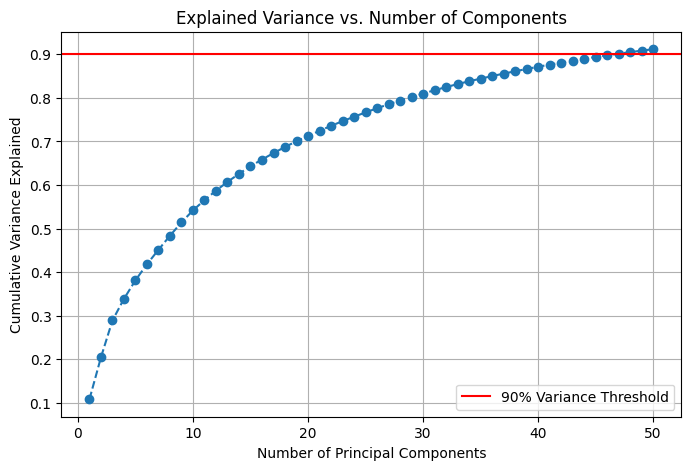

In [168]:
from sklearn.decomposition import PCA
# Perform PCA keeping only the top 2 principal components
pca = PCA(n_components=50)
aligned_heartbeats_reduced=pca.fit_transform(aligned_heartbeats_Matrix)
explained_variance_ratio_aligned_heartbeats = pca.explained_variance_ratio_
plot_cumulative_variance(explained_variance_ratio_aligned_heartbeats)

In [171]:

aligned_heartbeats_reduced.shape

(138, 50)

### Step 2 Apply GMM to the reduced representation of the alignes heartbeat signals

In [172]:
from sklearn.mixture import GaussianMixture
# Fit the GMM
gmmData= aligned_heartbeats_reduced
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(gmmData)
weights = gmm.weights_
print("Weights of each Gaussian component:", weights)
means = gmm.means_
print("Means of each Gaussian component:\n", means)
covariances = gmm.covariances_
print("Covariances of each Gaussian component:\n", covariances)

Weights of each Gaussian component: [1.]
Means of each Gaussian component:
 [[-3.08931624e-15  3.75866809e-15  1.64763533e-15  3.08931624e-16
   2.57443020e-17 -1.86646190e-15  2.44570869e-16 -1.80210114e-16
  -9.78283477e-16  2.17861156e-15  2.70315171e-16 -8.04509438e-16
  -1.54465812e-16 -2.44570869e-16 -1.00402778e-15  4.27999021e-16
   6.56479702e-16 -8.88178420e-16  5.14886040e-16  2.60661058e-16
  -2.31698718e-16  1.54465812e-16  1.02977208e-16 -2.57443020e-16
   4.63397436e-16  3.02495549e-16 -8.36689816e-17  1.67337963e-16
   6.95096155e-16 -2.18826567e-16  2.57443020e-16 -2.23653624e-16
  -2.89623398e-17  1.73774039e-16  6.56479702e-16  4.05472757e-16
  -1.73774039e-16 -4.39262153e-16 -2.70315171e-16  2.41352831e-16
  -6.33953437e-16 -2.83187322e-16  8.36689816e-17 -1.35157586e-16
  -7.01532230e-16 -6.43607551e-16 -2.34916756e-16 -4.66615474e-17
   7.20840457e-16  1.48029737e-16]]
Covariances of each Gaussian component:
 [[[ 3.14905446e+01 -2.80492813e-14  7.44404878e-15 ... 

[ -80.71718377  -91.93045901 -140.65474922 -107.92784198  -79.00731226
  -98.05516899 -110.52273143 -142.22700131 -119.41606502  -91.96610867
 -101.60064811  -86.80065993  -81.63940376  -89.45676208  -98.27548364
  -88.4185024   -92.97348452 -135.19659549  -96.31303854  -79.74621139
  -92.97605598  -78.53885274  -96.01622677 -105.10031108  -78.15362086
  -82.06173197  -89.6738233  -126.0422827  -115.22779927  -95.66914727
  -82.24421719  -94.10881539 -133.92371715  -95.66648023 -107.22293387
 -102.74846113  -89.98513528 -142.53570402 -130.0310347  -126.63753509
 -112.87284496  -97.02922463  -83.11140779  -83.52215887 -118.1852984
 -116.15561998  -95.61972109  -99.68368719 -128.86633967 -131.35689383
 -104.99072706 -104.78249425  -94.27759298 -113.8874476   -80.92643694
  -84.0862996  -118.22189809  -90.58687791 -102.04483196 -113.18722558
 -105.98115206 -105.69352105  -95.83332173  -91.03471737 -120.57155399
 -104.18268166  -83.83750686 -140.78326138 -100.02022983  -85.65490633
  -86.0

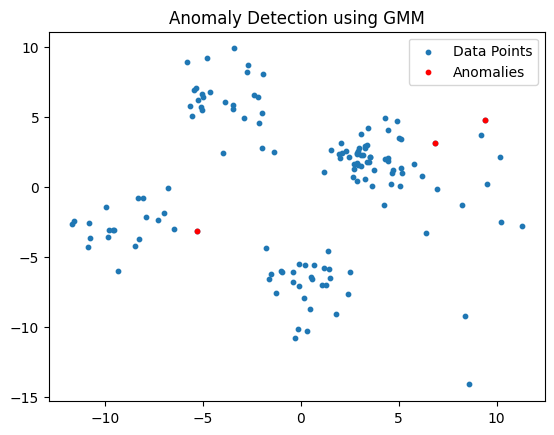

In [173]:
# Calculate the probability of each data point
scores = gmm.score_samples(gmmData)

# Set the threshold for anomalies
threshold = np.percentile(scores, 2)

# Identify anomalies
anomalies = gmmData[scores < threshold]
anomalies_idx= list(np.where(scores < threshold)[0])

import matplotlib.pyplot as plt

print(scores)
plt.scatter(gmmData[:, 1], gmmData[:, 2], s=10, label='Data Points')
plt.scatter(anomalies[:, 1], anomalies[:, 2], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

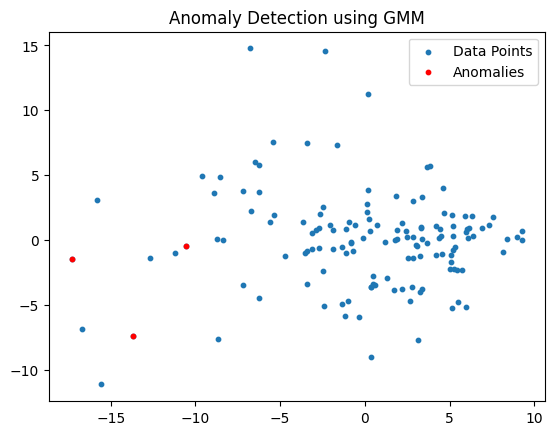

In [221]:
plt.scatter(gmmData[:, 0], gmmData[:, 3], s=10, label='Data Points')
plt.scatter(anomalies[:, 0], anomalies[:, 3], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

In [174]:
len(scores)

138

In [177]:
anomalies_idx

[np.int64(7), np.int64(37), np.int64(67)]

### Step 3 Plot Outliers

In [207]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def dominant_frequency(component, sr):
    freqs = fftfreq(len(component), 1 / sr)
    fft_vals = np.abs(fft(component))
    peak_freq = freqs[np.argmax(fft_vals)]
    return peak_freq

def plot_samples(matrix, sample_indices=None, sr=360):
    """
    Plots each sample from a given matrix with its own subplot.

    Parameters:
        matrix (numpy.ndarray): A matrix of shape (numberOfSamples, numberOfFeatures).
        sample_indices (list, optional): A list of indices to plot specific samples.
                                          If None, plot all samples.
        sr (int, optional): Sampling rate or a relevant parameter needed for frequency analysis.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)

    # Determine which samples to plot
    if sample_indices is not None:
        # Filter matrix to only include specified rows
        matrix = matrix[sample_indices]
    else:
        sample_indices = list(range(matrix.shape[0]))

    # Create subplots: One subplot per sample
    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, num_samples * 3), sharex=True)

    # If there's only one subplot (one sample), make sure `axes` is a list for iteration
    if num_samples == 1:
        axes = [axes]

    # Plot each sample in its own subplot
    for i, ax in enumerate(axes):
        sample = fetus[i][0]
        sample_idx = sample_indices[i]

        # Plot the sample
        ax.plot(sample, label=f'Sample {sample_idx}')
        print(sample.shape)
        sample_freq = dominant_frequency(sample,360)
        sample_bpm = sample_freq*60
        sample_file = fetus[sample_idx][1]

        # Set titles and labels for the subplot
        ax.set_title(f"File {sample_file} | Sample {sample_idx} | Frequency: {sample_freq:.2f} Hz | BPM: {sample_bpm:.2f}")
        ax.set_ylabel("Feature Value = Current")
        ax.legend()
        ax.grid(True)

    # Set the x-axis label only once at the bottom
    plt.xlabel("Feature Index = Time")#
    plt.tight_layout()

    plt.show()

(1500,)
(2365,)
(1760,)


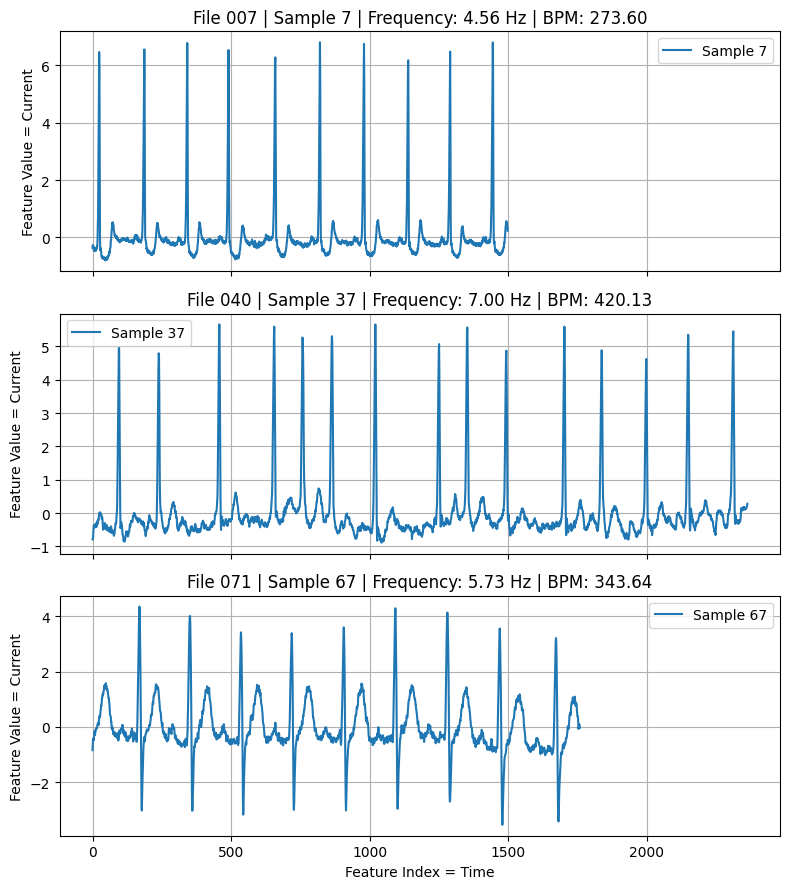

In [208]:
plot_samples(aligned_heartbeats_Matrix, anomalies_idx)

## GMM Clustering with Matrix Profiles







package: https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

why use the matrix profile? : https://www.youtube.com/watch?v=T9_z7EpA8QM

papers: https://www.cs.ucr.edu/~eamonn/MatrixProfile.html

### Step 1 Compute the matrix profile with the aligned heartbeats

In [216]:
import numpy as np
import stumpy

def compute_distance_profiles(signal_matrix, m):
    """
    Compute the distance profiles for a matrix of signals using STUMPY.
    
    Parameters:
    - signal_matrix: numpy.ndarray of shape (n_samples, n_measures)
        The input matrix where each row represents a time series signal.
    - m: int
        The subsequence window size for computing the matrix profile.
        
    Returns:
    - profile_matrix: numpy.ndarray of shape (n_samples, n_profiles)
        A 2D array where each row is the distance profile for a corresponding signal.
    """
    if not isinstance(signal_matrix, np.ndarray):
        raise ValueError("signal_matrix must be a numpy array.")
    
    n_samples, _ = signal_matrix.shape
    profiles = []
    
    for i in range(n_samples):
        signal = signal_matrix[i]
        distance_profile = stumpy.stump(signal, m)[:, 0]  # Extract matrix profile column
        profiles.append(distance_profile)
    
    # Convert the list of profiles to a 2D NumPy array
    profile_matrix = np.array(profiles)
    
    return profile_matrix

In [217]:
aligned_heartbeats_profiles = compute_distance_profiles(aligned_heartbeats_Matrix, m=50)

In [218]:
aligned_heartbeats_profiles.shape

(138, 1451)

### Step 2 Apply PCA to the matrix Profiles

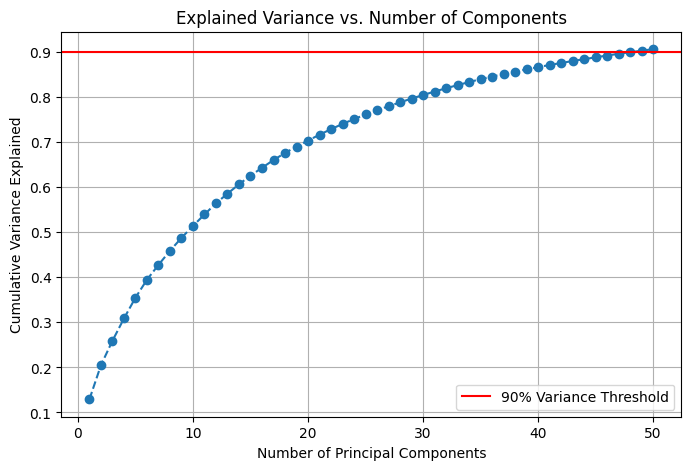

In [222]:
from sklearn.decomposition import PCA
# Perform PCA keeping only the top 2 principal components
pca = PCA(n_components=50)
aligned_profiles_reduced=pca.fit_transform(aligned_heartbeats_profiles)
explained_variance_ratio_profiles= pca.explained_variance_ratio_
plot_cumulative_variance(explained_variance_ratio_profiles)

In [225]:
aligned_profiles_reduced.shape

(138, 50)

### Step 3 Apply GMM to the reduces representation of the matrix profiles

In [226]:
from sklearn.mixture import GaussianMixture
# Fit the GMM
gmmData= aligned_profiles_reduced
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(gmmData)
weights = gmm.weights_
print("Weights of each Gaussian component:", weights)
means = gmm.means_
print("Means of each Gaussian component:\n", means)
covariances = gmm.covariances_
print("Covariances of each Gaussian component:\n", covariances)

Weights of each Gaussian component: [1.]
Means of each Gaussian component:
 [[ 2.05954416e-15  3.86164530e-16  1.44168091e-15  2.95415866e-15
   1.02977208e-16 -1.02977208e-15 -1.54465812e-15  2.49719730e-15
   5.92118946e-16 -7.01532230e-16 -1.54465812e-15  6.50043626e-16
   6.56479702e-16 -1.13274929e-15  1.46742522e-15 -9.52539175e-16
   6.69351853e-16 -5.14886040e-16  1.11987714e-15 -4.05472757e-16
   2.57443020e-15  7.80374155e-16  1.08126068e-15  1.08769676e-15
   3.60420228e-16 -3.60420228e-16  4.63397436e-16  1.02977208e-16
  -2.18826567e-16  1.18423789e-15 -1.03620816e-15  1.93082265e-16
  -1.13274929e-15 -1.64763533e-15 -2.05954416e-16  1.44168091e-15
   2.39743813e-16 -8.17381589e-16 -2.05954416e-16  7.53020834e-16
   1.24216257e-15 -2.83187322e-16 -2.67097133e-16 -1.17136574e-15
   1.24859865e-15 -4.56961361e-16 -1.36444801e-15  3.21803775e-17
  -1.28721510e-16  1.31939548e-15]]
Covariances of each Gaussian component:
 [[[ 2.44462253e+02  4.03371001e-14  1.38869137e-14 ... 

[-133.92386707 -134.46784973 -149.3853119  -158.10665305 -141.47726631
 -155.64992709 -152.3727624  -156.63545983 -153.80375302 -157.91731054
 -146.18088179 -139.06588415 -137.79161816 -138.41376863 -148.76049674
 -141.97635957 -146.56767143 -165.73859747 -144.83640482 -134.12320291
 -145.25545578 -134.60078874 -144.70330012 -163.18430147 -145.36394395
 -133.50784629 -150.76380283 -161.8438857  -162.73527086 -152.77785596
 -134.4736354  -153.62266593 -155.36434911 -140.0760079  -139.34246467
 -153.97651171 -146.28954044 -168.09745894 -147.26048628 -144.05352399
 -138.54927659 -156.41303886 -144.38554792 -142.78129659 -144.1234856
 -169.49530448 -156.47013232 -149.26788837 -161.39906762 -157.67863878
 -139.05692355 -139.40213641 -140.55238286 -152.18681531 -141.98217727
 -145.97334471 -141.49641401 -159.52550685 -145.45283533 -147.89538471
 -146.32943631 -146.00351859 -145.96600255 -147.78215102 -138.19084209
 -152.92335686 -155.6055024  -163.08513204 -139.73152894 -140.9522229
 -142.79

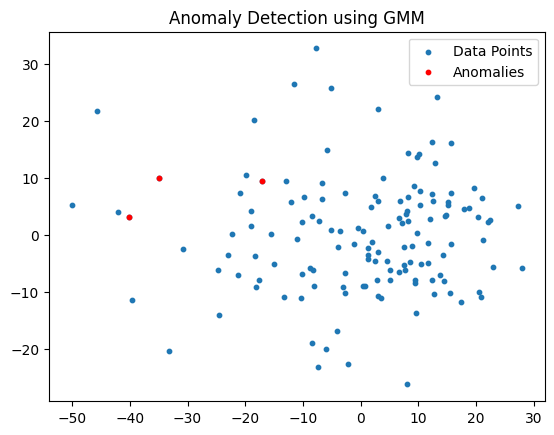

In [232]:
# Calculate the probability of each data point
scores = gmm.score_samples(gmmData)

# Set the threshold for anomalies
threshold = np.percentile(scores, 2)

# Identify anomalies
anomalies = gmmData[scores < threshold]
anomalies_idx= list(np.where(scores < threshold)[0])

import matplotlib.pyplot as plt

print(scores)
plt.scatter(gmmData[:, 0], gmmData[:, 2], s=10, label='Data Points')
plt.scatter(anomalies[:, 0], anomalies[:, 2], color='r', s=10, label='Anomalies')
plt.legend()
plt.title('Anomaly Detection using GMM')
plt.show()

In [229]:
anomalies_idx

[np.int64(37), np.int64(45), np.int64(87)]

### Step 4 Plot Outliers

(1500,)
(2365,)
(1760,)


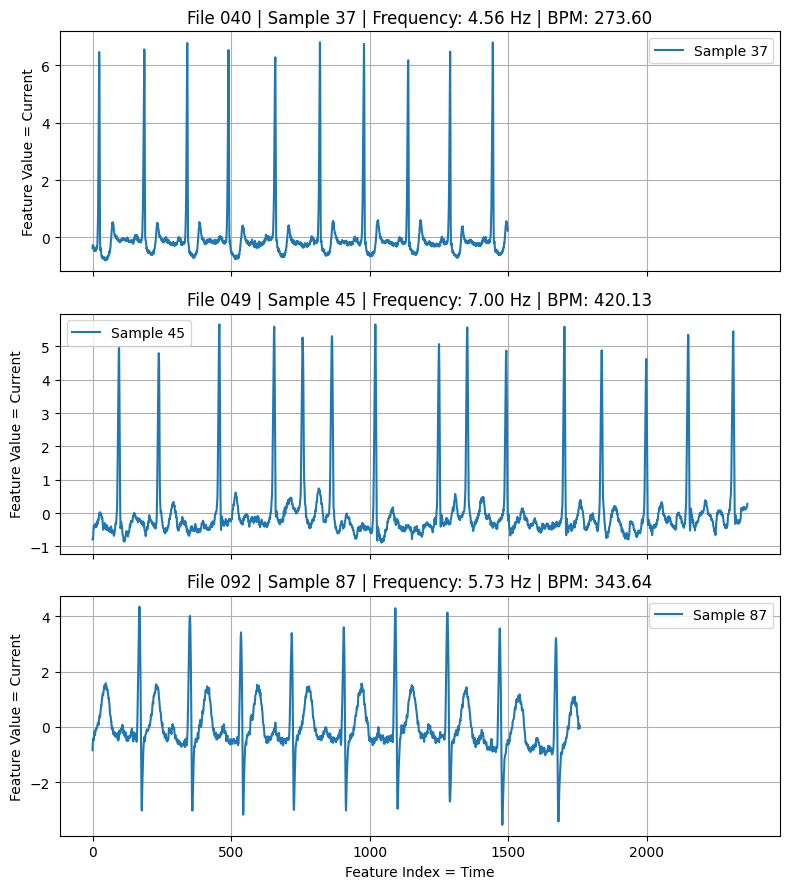

In [230]:
plot_samples(aligned_heartbeats_Matrix, anomalies_idx)